# **Predictive Analytics for Cost-Efficient Marketing Campaign Strategy**
## **Business Context**
Marketing campaigns often suffer from low response rates (~15%), resulting in high outreach costs and low efficiency.
Instead of sending campaigns to all customers, we aim to:
* Predict customer response likelihood
* Rank customers by predicted probability
* Target only high-probability customers
* Maximize ROI under budget constraints
## **Key Results**
* Targeting top 30% customers captures ~83% of responders
* Response rate improves from 15% → ~42%
* Campaign outreach can be reduced by ~70%
* Logistic Regression performs comparably to XGBoost in business lift

### **1. Importing Libraries and Dataset Ingestion**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

from xgboost import XGBClassifier

In [3]:
df = pd.read_excel("marketing_campaign.xlsx")
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,3,0,0,0,0,0,0,3,11,0


In [5]:
df.shape

(2240, 29)

### **2. Exploratory Data Analysis (EDA)**

#### **2.1 Target Distribution**

In [7]:
response_rate = df["Response"].mean()
print("Baseline Response Rate:", response_rate)

Baseline Response Rate: 0.14910714285714285


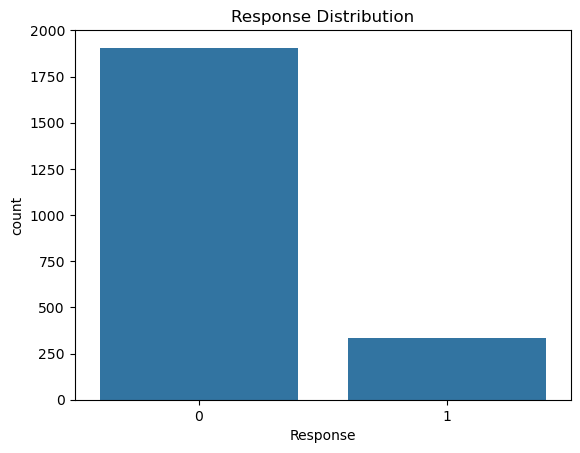

In [9]:
sns.countplot(x="Response", data=df)
plt.title("Response Distribution")
plt.show()

#### **2.2 Income Distribution**

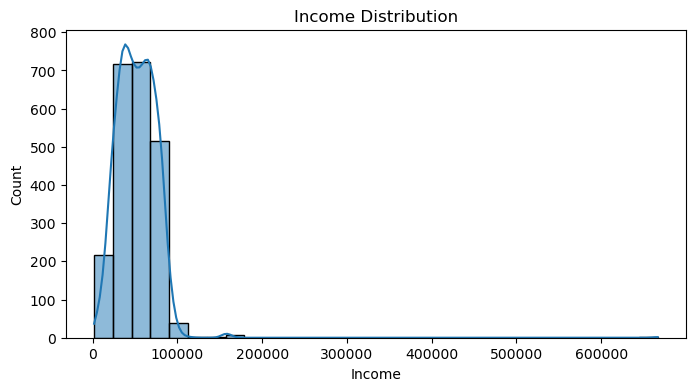

In [11]:
plt.figure(figsize=(8,4))
sns.histplot(df["Income"], bins=30, kde=True)
plt.title("Income Distribution")
plt.show()

#### **2.3 Purchase Behavior**

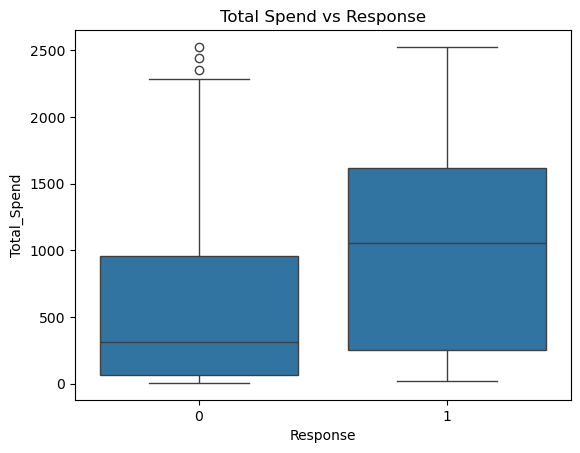

In [13]:
spend_cols = [
    "MntWines", "MntFruits", "MntMeatProducts",
    "MntFishProducts", "MntSweetProducts", "MntGoldProds"
]

df["Total_Spend"] = df[spend_cols].sum(axis=1)

sns.boxplot(x="Response", y="Total_Spend", data=df)
plt.title("Total Spend vs Response")
plt.show()

#### **2.4 Campaign History**

In [15]:
campaign_cols = [
    "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3",
    "AcceptedCmp4", "AcceptedCmp5"
]

df[campaign_cols].sum()

AcceptedCmp1    144
AcceptedCmp2     30
AcceptedCmp3    163
AcceptedCmp4    167
AcceptedCmp5    163
dtype: int64

### **3. Feature Engineering**

#### **3.1 Handle Missing Income**

In [17]:
df["Income_Missing"] = df["Income"].isna().astype(int)
df["Income"] = df["Income"].fillna(df["Income"].median())

#### **3.2 Create Age**

In [19]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])

reference_year = df["Dt_Customer"].dt.year.max()
df["Age"] = reference_year - df["Year_Birth"]

#### **3.3 Create Customer Tenure**

In [21]:
df["Customer_Tenure"] = (
    df["Dt_Customer"].max() - df["Dt_Customer"]
).dt.days

#### **3.4 Drop Redundant Columns**

In [23]:
df = df.drop(["ID", "Year_Birth", "Dt_Customer"], axis=1)

### **4. Encoding**

In [26]:
df_encoded = pd.get_dummies(df, drop_first=True)

### **5. Train/Test Split**

In [29]:
X = df_encoded.drop("Response", axis=1)
y = df_encoded["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### **6. Logistic Regression Model**

In [32]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000))
])

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:, 1]

### **7. Business Lift Evaluation**

In [35]:
def top_k_metrics(y_true, probabilities, k=0.30):
    df_eval = pd.DataFrame({
        "actual": y_true,
        "proba": probabilities
    }).sort_values("proba", ascending=False)
    
    n_top = int(k * len(df_eval))
    top_segment = df_eval.head(n_top)
    
    capture_rate = top_segment["actual"].sum() / df_eval["actual"].sum()
    response_rate = top_segment["actual"].mean()
    
    return capture_rate, response_rate

In [37]:
capture_30, response_30 = top_k_metrics(y_test, proba, 0.30)
capture_10, response_10 = top_k_metrics(y_test, proba, 0.10)

print("Capture @30%:", capture_30)
print("Response @30%:", response_30)
print("Capture @10%:", capture_10)
print("Response @10%:", response_10)

Capture @30%: 0.835820895522388
Response @30%: 0.417910447761194
Capture @10%: 0.44776119402985076
Response @10%: 0.6818181818181818


### **8. ROC Curve**

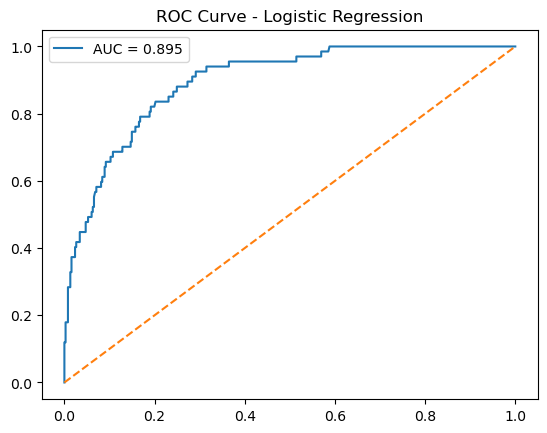

In [40]:
fpr, tpr, _ = roc_curve(y_test, proba)
auc_score = roc_auc_score(y_test, proba)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.legend()
plt.title("ROC Curve - Logistic Regression")
plt.show()

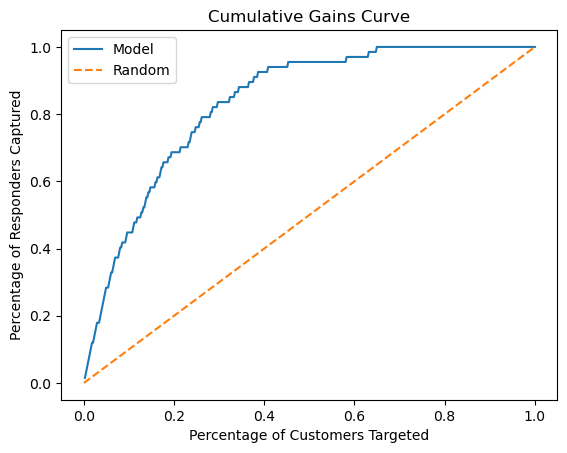

In [42]:
df_eval = pd.DataFrame({
    "actual": y_test,
    "proba": proba
}).sort_values("proba", ascending=False).reset_index(drop=True)

df_eval["cumulative_responders"] = df_eval["actual"].cumsum()
total_responders = df_eval["actual"].sum()

df_eval["capture_rate"] = df_eval["cumulative_responders"] / total_responders
df_eval["population_pct"] = (df_eval.index + 1) / len(df_eval)

plt.figure()
plt.plot(df_eval["population_pct"], df_eval["capture_rate"], label="Model")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("Percentage of Customers Targeted")
plt.ylabel("Percentage of Responders Captured")
plt.title("Cumulative Gains Curve")
plt.legend()
plt.show()

### **9. XGBoost Comparison**

In [50]:
cost_per_contact = 1
profit_per_response = 20

total_customers = len(y_test)
baseline_responses = y_test.sum()

baseline_profit = (baseline_responses * profit_per_response) - (total_customers * cost_per_contact)

targeted_contacts = int(0.30 * total_customers)
targeted_responses = capture_30 * baseline_responses

targeted_profit = (targeted_responses * profit_per_response) - (targeted_contacts * cost_per_contact)

print("Baseline Profit:", baseline_profit)
print("Targeted Profit:", targeted_profit)

Baseline Profit: 892
Targeted Profit: 986.0


## **Final Summary**

* This project reframes marketing response prediction as a resource allocation problem rather than a pure classification task. Instead of sending campaigns to all customers (baseline response rate ~15%), we built a probability-based ranking system that prioritizes customers by likelihood of response. By targeting only the top 30% highest-scoring customers, we capture approximately 83% of all responders while increasing response rate to ~42%. In business terms, this means the company can reduce outreach volume by 70% while preserving the majority of conversions — significantly improving marketing efficiency and return on investment.

* More importantly, this work demonstrates that predictive modeling is not about increasing model accuracy alone, but about optimizing decisions under budget constraints. The model enables flexible targeting strategies: when budget is tight (e.g., top 10%), precision increases; when broader reach is possible (e.g., top 30%), total capture remains high. This illustrates the core value of applied machine learning in business — transforming raw predictions into actionable, cost-efficient strategy.

In [19]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
df["Customer_Tenure"] = (
    df["Dt_Customer"].max() - df["Dt_Customer"]
).dt.days

In [21]:
df = df.drop(["ID", "Year_Birth", "Dt_Customer"], axis=1)

In [23]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.shape

(2240, 39)

In [25]:
X = df_encoded.drop("Response", axis=1)
y = df_encoded["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train response rate:", y_train.mean())
print("Test response rate:", y_test.mean())

Train response rate: 0.14899553571428573
Test response rate: 0.14955357142857142


In [27]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000))
])

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:, 1]

In [29]:
def top_k_metrics(y_true, probabilities, k=0.30):
    df_eval = pd.DataFrame({
        "actual": y_true,
        "proba": probabilities
    }).sort_values("proba", ascending=False)
    
    n_top = int(k * len(df_eval))
    top_segment = df_eval.head(n_top)
    
    capture_rate = top_segment["actual"].sum() / df_eval["actual"].sum()
    response_rate = top_segment["actual"].mean()
    
    return capture_rate, response_rate

In [31]:
capture_30, response_30 = top_k_metrics(y_test, proba, 0.30)

print("Capture Rate @30%:", capture_30)
print("Response Rate @30%:", response_30)

Capture Rate @30%: 0.835820895522388
Response Rate @30%: 0.417910447761194


In [33]:
capture_10, response_10 = top_k_metrics(y_test, proba, 0.10)

print("Capture Rate @10%:", capture_10)
print("Response Rate @10%:", response_10)

Capture Rate @10%: 0.44776119402985076
Response Rate @10%: 0.6818181818181818


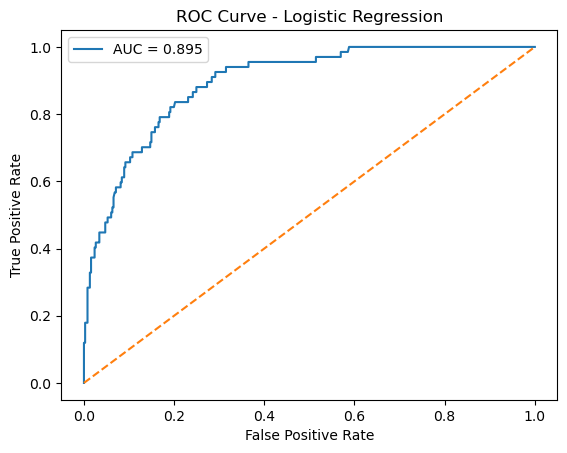

In [35]:
fpr, tpr, _ = roc_curve(y_test, proba)
auc_score = roc_auc_score(y_test, proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

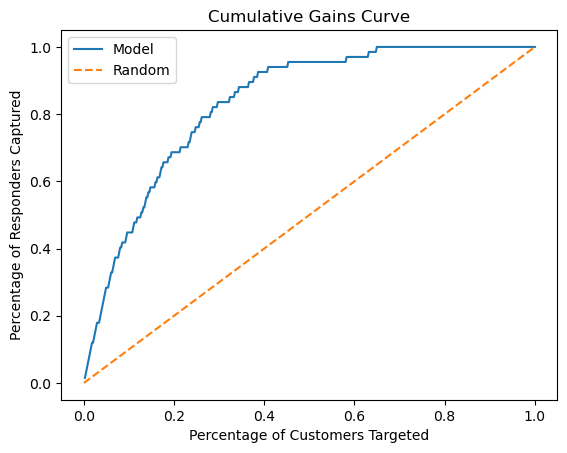

In [37]:
df_eval = pd.DataFrame({
    "actual": y_test,
    "proba": proba
}).sort_values("proba", ascending=False).reset_index(drop=True)

df_eval["cumulative_responders"] = df_eval["actual"].cumsum()
total_responders = df_eval["actual"].sum()

df_eval["capture_rate"] = df_eval["cumulative_responders"] / total_responders
df_eval["population_pct"] = (df_eval.index + 1) / len(df_eval)

plt.figure()
plt.plot(df_eval["population_pct"], df_eval["capture_rate"], label="Model")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("Percentage of Customers Targeted")
plt.ylabel("Percentage of Responders Captured")
plt.title("Cumulative Gains Curve")
plt.legend()
plt.show()

In [39]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

In [41]:
xgb_capture_30, xgb_response_30 = top_k_metrics(y_test, xgb_proba, 0.30)

print("XGBoost Capture @30%:", xgb_capture_30)
print("XGBoost Response @30%:", xgb_response_30)

XGBoost Capture @30%: 0.8507462686567164
XGBoost Response @30%: 0.4253731343283582


In [43]:
cost_per_contact = 1
profit_per_response = 20

total_customers = len(y_test)
baseline_contacts = total_customers
baseline_responses = y_test.sum()

baseline_profit = (baseline_responses * profit_per_response) - (baseline_contacts * cost_per_contact)

targeted_contacts = int(0.30 * total_customers)
targeted_responses = capture_30 * baseline_responses

targeted_profit = (targeted_responses * profit_per_response) - (targeted_contacts * cost_per_contact)

print("Baseline Profit:", baseline_profit)
print("Targeted Profit:", targeted_profit)

Baseline Profit: 892
Targeted Profit: 986.0
